# 1. Load Libraries

In [160]:
import pandas as pd
import numpy as np
import pytorch_forecasting as pf
from tabulate import tabulate
from tqdm import tqdm
from torch.utils.data import random_split, TensorDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import (ConcatDataset, DataLoader, Dataset, Subset,
                              random_split)
from torchvision import datasets, transforms
import seaborn as sns
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import pytorch_forecasting as pf
from pytorch_forecasting.metrics import QuantileLoss
from sklearn.model_selection import train_test_split
from pytorch_forecasting.data import GroupNormalizer
import torch.nn as nn

In [161]:
path = r"C:\Users\User\Documents\Semester 07\EE4750 - Data Analytics in Power Systems\WindPowerForecastingData TASK.xlsx\WindPowerForecastingData TASK.xlsx"
data = pd.read_excel(path, engine='openpyxl')
print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+----+---------------+-------------+---------+-----------+---------+-----------+
|    | TIMESTAMP     |   TARGETVAR |     U10 |       V10 |    U100 |      V100 |
|----+---------------+-------------+---------+-----------+---------+-----------|
|  0 | 20120101 1:00 |   0         | 2.1246  | -2.68197  | 2.86428 | -3.66608  |
|  1 | 20120101 2:00 |   0.0548791 | 2.52169 | -1.79696  | 3.34486 | -2.46476  |
|  2 | 20120101 3:00 |   0.110234  | 2.67221 | -0.822516 | 3.50845 | -1.21409  |
|  3 | 20120101 4:00 |   0.165116  | 2.4575  | -0.143642 | 3.21523 | -0.355546 |
|  4 | 20120101 5:00 |   0.15694   | 2.2459  |  0.389576 | 2.95768 |  0.332701 |
+----+---------------+-------------+---------+-----------+---------+-----------+


In [162]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data = data.set_index('TIMESTAMP')
print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+---------------------+-------------+---------+-----------+---------+-----------+
| TIMESTAMP           |   TARGETVAR |     U10 |       V10 |    U100 |      V100 |
|---------------------+-------------+---------+-----------+---------+-----------|
| 2012-01-01 01:00:00 |   0         | 2.1246  | -2.68197  | 2.86428 | -3.66608  |
| 2012-01-01 02:00:00 |   0.0548791 | 2.52169 | -1.79696  | 3.34486 | -2.46476  |
| 2012-01-01 03:00:00 |   0.110234  | 2.67221 | -0.822516 | 3.50845 | -1.21409  |
| 2012-01-01 04:00:00 |   0.165116  | 2.4575  | -0.143642 | 3.21523 | -0.355546 |
| 2012-01-01 05:00:00 |   0.15694   | 2.2459  |  0.389576 | 2.95768 |  0.332701 |
+---------------------+-------------+---------+-----------+---------+-----------+


In [163]:
# Add time-based features using the index
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['day_of_year'] = data.index.dayofyear
data['week_of_year'] = data.index.isocalendar().week
data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)

# Cyclical encoding for temporal features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

In [164]:
print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------+
| TIMESTAMP           |   TARGETVAR |     U10 |       V10 |    U100 |      V100 |   hour |   day_of_week |   month |   day_of_year |   week_of_year |   is_weekend |   hour_sin |   hour_cos |   day_sin |   day_cos |   month_sin |   month_cos |
|---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------|
| 2012-01-01 01:00:00 |   0         | 2.1246  | -2.68197  | 2.86428 | -3.66608  |      1 |             6 |       1 |             1 |             52 |            1 |   0.258819 |   0.965926 | -0.781831 |   0.62349 |         0.5 |    0.866025 |
| 2012-01-01 02:00:00 |   0.

In [165]:
# Handle missing values
#initial_rows = len(data)
#data = data.dropna().reset_index(drop=True)
data['time_idx'] = range(len(data))
data['series_id'] = 0  # Single time series identifier

print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------+------------+-------------+
| TIMESTAMP           |   TARGETVAR |     U10 |       V10 |    U100 |      V100 |   hour |   day_of_week |   month |   day_of_year |   week_of_year |   is_weekend |   hour_sin |   hour_cos |   day_sin |   day_cos |   month_sin |   month_cos |   time_idx |   series_id |
|---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------+------------+-------------|
| 2012-01-01 01:00:00 |   0         | 2.1246  | -2.68197  | 2.86428 | -3.66608  |      1 |             6 |       1 |             1 |             52 |            1 |   0.258819 |   0.965926 |

In [166]:
print(tabulate(data.head(), headers='keys', tablefmt='psql'))
data.isnull().sum()
data = data.fillna(method='ffill').fillna(method='bfill')
print(tabulate(data.head(), headers='keys', tablefmt='psql'))
data.isnull().sum()

+---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------+------------+-------------+
| TIMESTAMP           |   TARGETVAR |     U10 |       V10 |    U100 |      V100 |   hour |   day_of_week |   month |   day_of_year |   week_of_year |   is_weekend |   hour_sin |   hour_cos |   day_sin |   day_cos |   month_sin |   month_cos |   time_idx |   series_id |
|---------------------+-------------+---------+-----------+---------+-----------+--------+---------------+---------+---------------+----------------+--------------+------------+------------+-----------+-----------+-------------+-------------+------------+-------------|
| 2012-01-01 01:00:00 |   0         | 2.1246  | -2.68197  | 2.86428 | -3.66608  |      1 |             6 |       1 |             1 |             52 |            1 |   0.258819 |   0.965926 |

C:\Users\User\AppData\Local\Temp\ipykernel_24908\4171517129.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


TARGETVAR       0
U10             0
V10             0
U100            0
V100            0
hour            0
day_of_week     0
month           0
day_of_year     0
week_of_year    0
is_weekend      0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_sin       0
month_cos       0
time_idx        0
series_id       0
dtype: int64

In [167]:
train_df, temp_df = train_test_split(
    data,
    test_size=0.4,       # 60% train
    random_state=42,
    shuffle=True
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,       # 20% val, 20% test
    random_state=42,
    shuffle=True
)

# --- base dataset definition (use same config for all) ---------------------
def make_ds(df: pd.DataFrame) -> TimeSeriesDataSet:
    return TimeSeriesDataSet(
        data=df,
        time_idx="time_idx",
        group_ids=["series_id"],
        target="TARGETVAR",
        min_encoder_length=168 // 4,
        max_encoder_length=168,
        min_prediction_length=1,
        max_prediction_length=12,
        time_varying_known_reals=[
            'U10', 'V10', 'U100', 'V100',
            'hour_sin', 'hour_cos',
            'day_sin', 'day_cos',
            'month_sin', 'month_cos'
        ],
        time_varying_unknown_reals=['TARGETVAR'],
        target_normalizer=GroupNormalizer(
            groups=["series_id"],
            transformation="softplus",
            center=True
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
        categorical_encoders={}
    )

training_data = make_ds(train_df)
validation_data = make_ds(val_df)
testing_data   = make_ds(test_df)

In [168]:
train_dataloader = training_data.to_dataloader(train=True, batch_size=64, num_workers=3, persistent_workers=True)
val_dataloader   = validation_data.to_dataloader(train=False, batch_size=64, num_workers=1, persistent_workers=True)
test_dataloader  = testing_data.to_dataloader(train=False, batch_size=64, num_workers=0)

print(f"🚂 Training samples: {len(training_data)}")
print(f"🚋 Validation samples: {len(validation_data)}")
print(f"🚃 Testing samples: {len(testing_data)}")

🚂 Training samples: 13043
🚋 Validation samples: 4833
🚃 Testing samples: 4844


In [169]:
#create tft model   
from pytorch_forecasting import MAE, RMSE , SMAPE


tft_model = TemporalFusionTransformer.from_dataset(
        training_data,
        hidden_size=64,
        learning_rate = 0.001,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss([0.1, 0.5, 0.9]),
        log_interval=10,
        reduce_on_plateau_patience=4,
        optimizer='adam',
        # Additional interpretability parameters
        logging_metrics=nn.ModuleList([MAE(), RMSE(), SMAPE()]),
    )


c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [170]:
checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",                 # folder to store ckpts
    filename="tft-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss",                    # metric to watch
    save_top_k=3,                          # keep best 3
    mode="min"
)

In [171]:
from lightning.pytorch import LightningModule  # ✅ new path
import torch

class TFTLightningModule(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        y_pred = out[0]
        loss = self.model.loss(y_pred, y)
        self.log(
            "train_loss", loss,
            on_step=True, on_epoch=True,
            prog_bar=True,
            batch_size=x["encoder_target"].shape[0]
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        y_pred = out[0]
        loss = self.model.loss(y_pred, y)
        self.log(
            "val_loss", loss,
            prog_bar=True,
            batch_size=x["encoder_target"].shape[0]
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.model.hparams.learning_rate
        )

# wrap the TFT model
tft_module = TFTLightningModule(tft_model)


In [172]:
# Configure trainer with comprehensive logging
trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    log_every_n_steps=50,
    enable_checkpointing=True,
    deterministic=True,  # For reproducible results
    callbacks = [checkpoint_cb]  # Add checkpoint callback
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [173]:
#Train the model
trainer.fit(
    tft_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
# path of best checkpoint
print("Best model saved at:", checkpoint_cb.best_model_path)

c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:701: Checkpoint directory C:\Users\User\Documents\GitHub\wind-power-prediction-tft\checkpoints exists and is not empty.

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | TemporalFusionTransformer | 254 K  | train
------------------------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.018     Total estimated model params size (MB)
540       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 203/203 [10:29<00:00,  0.32it/s, v_num=36, train_loss_step=0.0494, val_loss=0.0705, train_loss_epoch=0.0506]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 203/203 [10:29<00:00,  0.32it/s, v_num=36, train_loss_step=0.0494, val_loss=0.0705, train_loss_epoch=0.0506]
Best model saved at: C:\Users\User\Documents\GitHub\wind-power-prediction-tft\checkpoints\tft-epoch=13-val_loss=0.0660.ckpt


In [174]:
from lightning.pytorch import LightningModule
# (make sure TFTLightningModule is defined exactly as during training)

# Load the saved LightningModule
best_module = TFTLightningModule.load_from_checkpoint(
    checkpoint_cb.best_model_path,
    model=tft_model   # <-- required if your __init__ needs the base TFT model
)

# Access the trained TemporalFusionTransformer
best_model = best_module.model


In [175]:
print(data.head())

                     TARGETVAR       U10       V10      U100      V100  hour  \
TIMESTAMP                                                                      
2012-01-01 01:00:00   0.000000  2.124600 -2.681966  2.864280 -3.666076     1   
2012-01-01 02:00:00   0.054879  2.521695 -1.796960  3.344859 -2.464761     2   
2012-01-01 03:00:00   0.110234  2.672210 -0.822516  3.508448 -1.214093     3   
2012-01-01 04:00:00   0.165116  2.457504 -0.143642  3.215233 -0.355546     4   
2012-01-01 05:00:00   0.156940  2.245898  0.389576  2.957678  0.332701     5   

                     day_of_week  month  day_of_year  week_of_year  \
TIMESTAMP                                                            
2012-01-01 01:00:00            6      1            1            52   
2012-01-01 02:00:00            6      1            1            52   
2012-01-01 03:00:00            6      1            1            52   
2012-01-01 04:00:00            6      1            1            52   
2012-01-01 05:00:00

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Predict and get the model inputs for timestamps
preds, x = best_model.predict(
    validation_data,
    mode="prediction",
    return_x=True,
    batch_size=64
)

# Make sure preds is 2-D: (samples, forecast_horizon)
if preds.ndim == 1:
    preds = preds[:, np.newaxis]

# We’ll plot the first forecast sample
sample_pred = preds[0]
decoder_idx = x[0]["decoder_time_idx"][0].cpu().numpy()   # forecast horizon indexes
series_id   = x[0]["decoder_target"][0].cpu().numpy()     # only needed if you have multiple series

# 2️⃣ Map integer time_idx → real TIMESTAMP
raw_df = validation_data.data
idx_to_time = dict(zip(raw_df["time_idx"], raw_df["TIMESTAMP"]))
plot_timestamps = [idx_to_time[i] for i in decoder_idx]

# Actual target values for the same horizon and series
target_col = validation_data.target
true_vals = raw_df.loc[
    (raw_df["time_idx"].isin(decoder_idx))
    & (raw_df["series_id"] == series_id),
    target_col
].values

# 3️⃣ Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(plot_timestamps, sample_pred, label="Predicted", color="blue", linewidth=2)
plt.plot(plot_timestamps, true_vals,    label="Actual",   color="orange", linewidth=2)
plt.title("TFT Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
# Test the model on test data
test_results = trainer.test(best_model, dataloaders=test_dataloader)
print(test_results)

c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 77/77 [00:33<00:00,  2.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE            0.3041379749774933
        test_RMSE           0.4081431031227112
       test_SMAPE           1.8375400304794312
        test_loss           0.30431482195854187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 0.30431482195854187, 'test_MAE': 0.3041379749774933, 'test_RMSE': 0.4081431031227112, 'test_SMAPE': 1.8375400304794312}]


c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\User\anaconda3\envs\wind-tft\lib\site-packages\pytorch_forecasting\models\base\_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 12, 4, 168]). Returning list instead of torch.Tensor.
  warnings.warn(


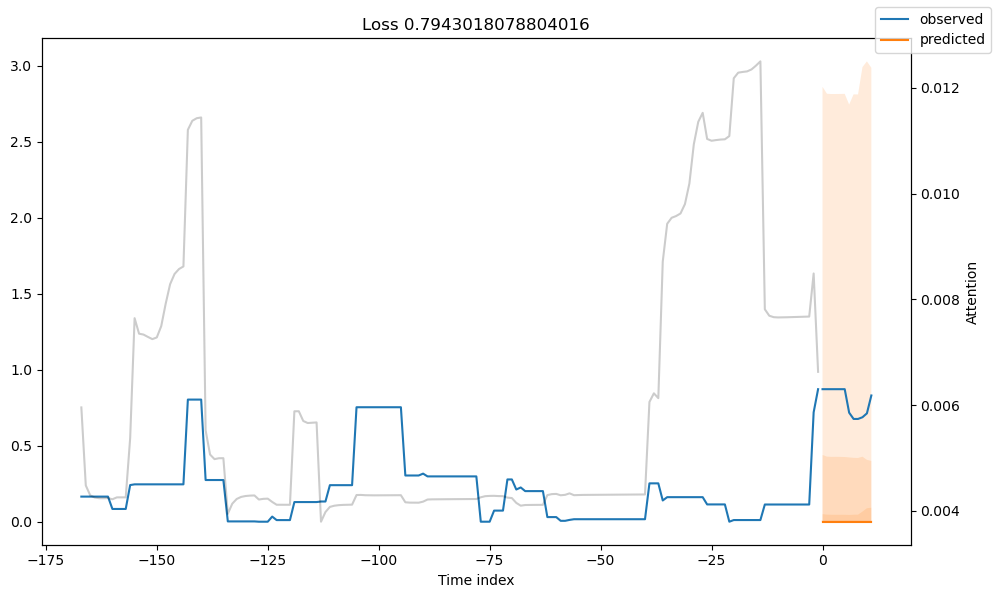

In [ ]:
# Get raw predictions and inputs from the model on the test set
raw_predictions = best_model.predict(test_dataloader, mode="raw", return_x=True)
# Extract 'output' and 'x' from the 'raw_predictions'
out = raw_predictions.output
x = raw_predictions.x

# Visualize predictions for the single available sample in the test set
fig, ax = plt.subplots(figsize=(10, 6))
best_model.plot_prediction(x=x, out=out, idx=0, add_loss_to_title=True, ax=ax)
plt.show()


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet

    
def evaluate_explainable_predictions(best_model, validation_data):
    """
    Evaluate TFT predictions for next 12 hours with quantiles.
    Handles both single-quantile (2D) and multi-quantile (3D) outputs.
    """
    QUANTILES = [0.1, 0.5, 0.9]
    config = {
        'description': '12 hours ahead',
        'max_prediction_length': validation_data.max_prediction_length,
        'max_encoder_length': validation_data.max_encoder_length
    }

    best_model.eval()
    
    # Predict
    predictions = best_model.predict(validation_data, mode="prediction", batch_size=256)

    # Ensure predictions are at least 3D
    if predictions.ndim == 2:  # shape: (num_samples, prediction_length)
        predictions = predictions[:, :, np.newaxis]  # add a singleton dimension for quantiles

    quantile_predictions = {}
    for i, q in enumerate(QUANTILES):
        if i < predictions.shape[2]:
            quantile_predictions[f'q{q}'] = predictions[:, :, i].numpy()
        else:
            # For missing quantiles, fill with median (q0.5)
            quantile_predictions[f'q{q}'] = predictions[:, :, predictions.shape[2]//2].numpy()

    median_predictions = quantile_predictions['q0.5']

    evaluation_results = {
        'config': config,
        'prediction_shape': median_predictions.shape,
        'num_forecasts': len(median_predictions),
        'forecast_horizon': config['max_prediction_length'],
        'quantile_predictions': quantile_predictions,
        'model_size': best_model.size()
    }

    print(f"Evaluation Results for {config['description']}:")
    print(f"  Prediction shape: {median_predictions.shape}")
    print(f"  Number of forecasts: {len(median_predictions)}")
    print(f"  Forecast horizon: {config['max_prediction_length']} hours")
    print(f"  Quantiles available: {list(QUANTILES)}")

    return evaluation_results

def plot_comprehensive_results(evaluation_results, num_samples=3):
    """
    Plot TFT results including uncertainty quantification (3 quantiles only).

    Args:
        evaluation_results: Output from evaluate_explainable_predictions
        num_samples: Number of forecast series to visualize
    """
    config = evaluation_results['config']
    quantile_predictions = evaluation_results['quantile_predictions']

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'TFT Forecasting Results: {config["description"]}', fontsize=16, fontweight='bold')

    # Panel 1: Sample forecasts with uncertainty bands
    ax1 = axes[0, 0]
    for i in range(min(num_samples, len(quantile_predictions['q0.5']))):
        time_steps = range(evaluation_results['forecast_horizon'])
        ax1.plot(time_steps, quantile_predictions['q0.5'][i], label=f'Sample {i+1} (Median)', linewidth=2)
        # Only 80% PI using q0.1 and q0.9
        ax1.fill_between(time_steps, quantile_predictions['q0.1'][i], quantile_predictions['q0.9'][i],
                         alpha=0.2, label=f'80% PI (Sample {i+1})' if i == 0 else "")
    ax1.set_title('Sample Forecasts with Uncertainty Quantification')
    ax1.set_xlabel('Hours Ahead')
    ax1.set_ylabel('Wind Power')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Average quantile distribution
    ax2 = axes[0, 1]
    avg_quantiles = [np.mean(pred) for pred in quantile_predictions.values()]
    labels = [k.replace('q', 'Q') for k in quantile_predictions.keys()]
    bars = ax2.bar(labels, avg_quantiles, color=plt.cm.viridis(np.linspace(0,1,len(labels))), alpha=0.8)
    ax2.set_title('Average Quantile Predictions')
    ax2.set_xlabel('Quantiles')
    ax2.set_ylabel('Average Predicted Value')
    ax2.grid(True, alpha=0.3)
    for bar, val in zip(bars, avg_quantiles):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01*max(avg_quantiles),
                 f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    # Panel 3: Prediction interval widths (only 80% PI)
    ax3 = axes[1, 0]
    pi_80_width = quantile_predictions['q0.9'] - quantile_predictions['q0.1']
    time_steps = range(evaluation_results['forecast_horizon'])
    ax3.plot(time_steps, np.mean(pi_80_width, axis=0), 'b-', linewidth=2, label='80% PI Width')
    ax3.fill_between(time_steps, np.mean(pi_80_width, axis=0), alpha=0.3, color='blue')
    ax3.set_title('Prediction Interval Width Over Forecast Horizon')
    ax3.set_xlabel('Hours Ahead')
    ax3.set_ylabel('Prediction Interval Width')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Panel 4: Median prediction vs forecast horizon
    ax4 = axes[1, 1]
    median_by_horizon = [np.mean(quantile_predictions['q0.5'][:, t]) for t in range(evaluation_results['forecast_horizon'])]
    ax4.plot(range(1, evaluation_results['forecast_horizon']+1), median_by_horizon, 'g-o', linewidth=2, label='Median Prediction')
    ax4.set_title('Median Prediction Across Horizon')
    ax4.set_xlabel('Forecast Horizon (Hours)')
    ax4.set_ylabel('Median Predicted Value')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nStatistical Summary for {config['description']}:")
    print("="*50)
    print(f"Average median prediction: {np.mean(quantile_predictions['q0.5']):.4f}")
    print(f"Prediction std deviation: {np.std(quantile_predictions['q0.5']):.4f}")
    print(f"Average 80% PI width: {np.mean(pi_80_width):.4f}")
    print(f"Forecast horizon: {evaluation_results['forecast_horizon']} hours")
    print(f"Number of forecasts: {evaluation_results['num_forecasts']}")




Evaluation Results for 12 hours ahead:
  Prediction shape: (4832, 12)
  Number of forecasts: 4832
  Forecast horizon: 12 hours
  Quantiles available: [0.1, 0.5, 0.9]


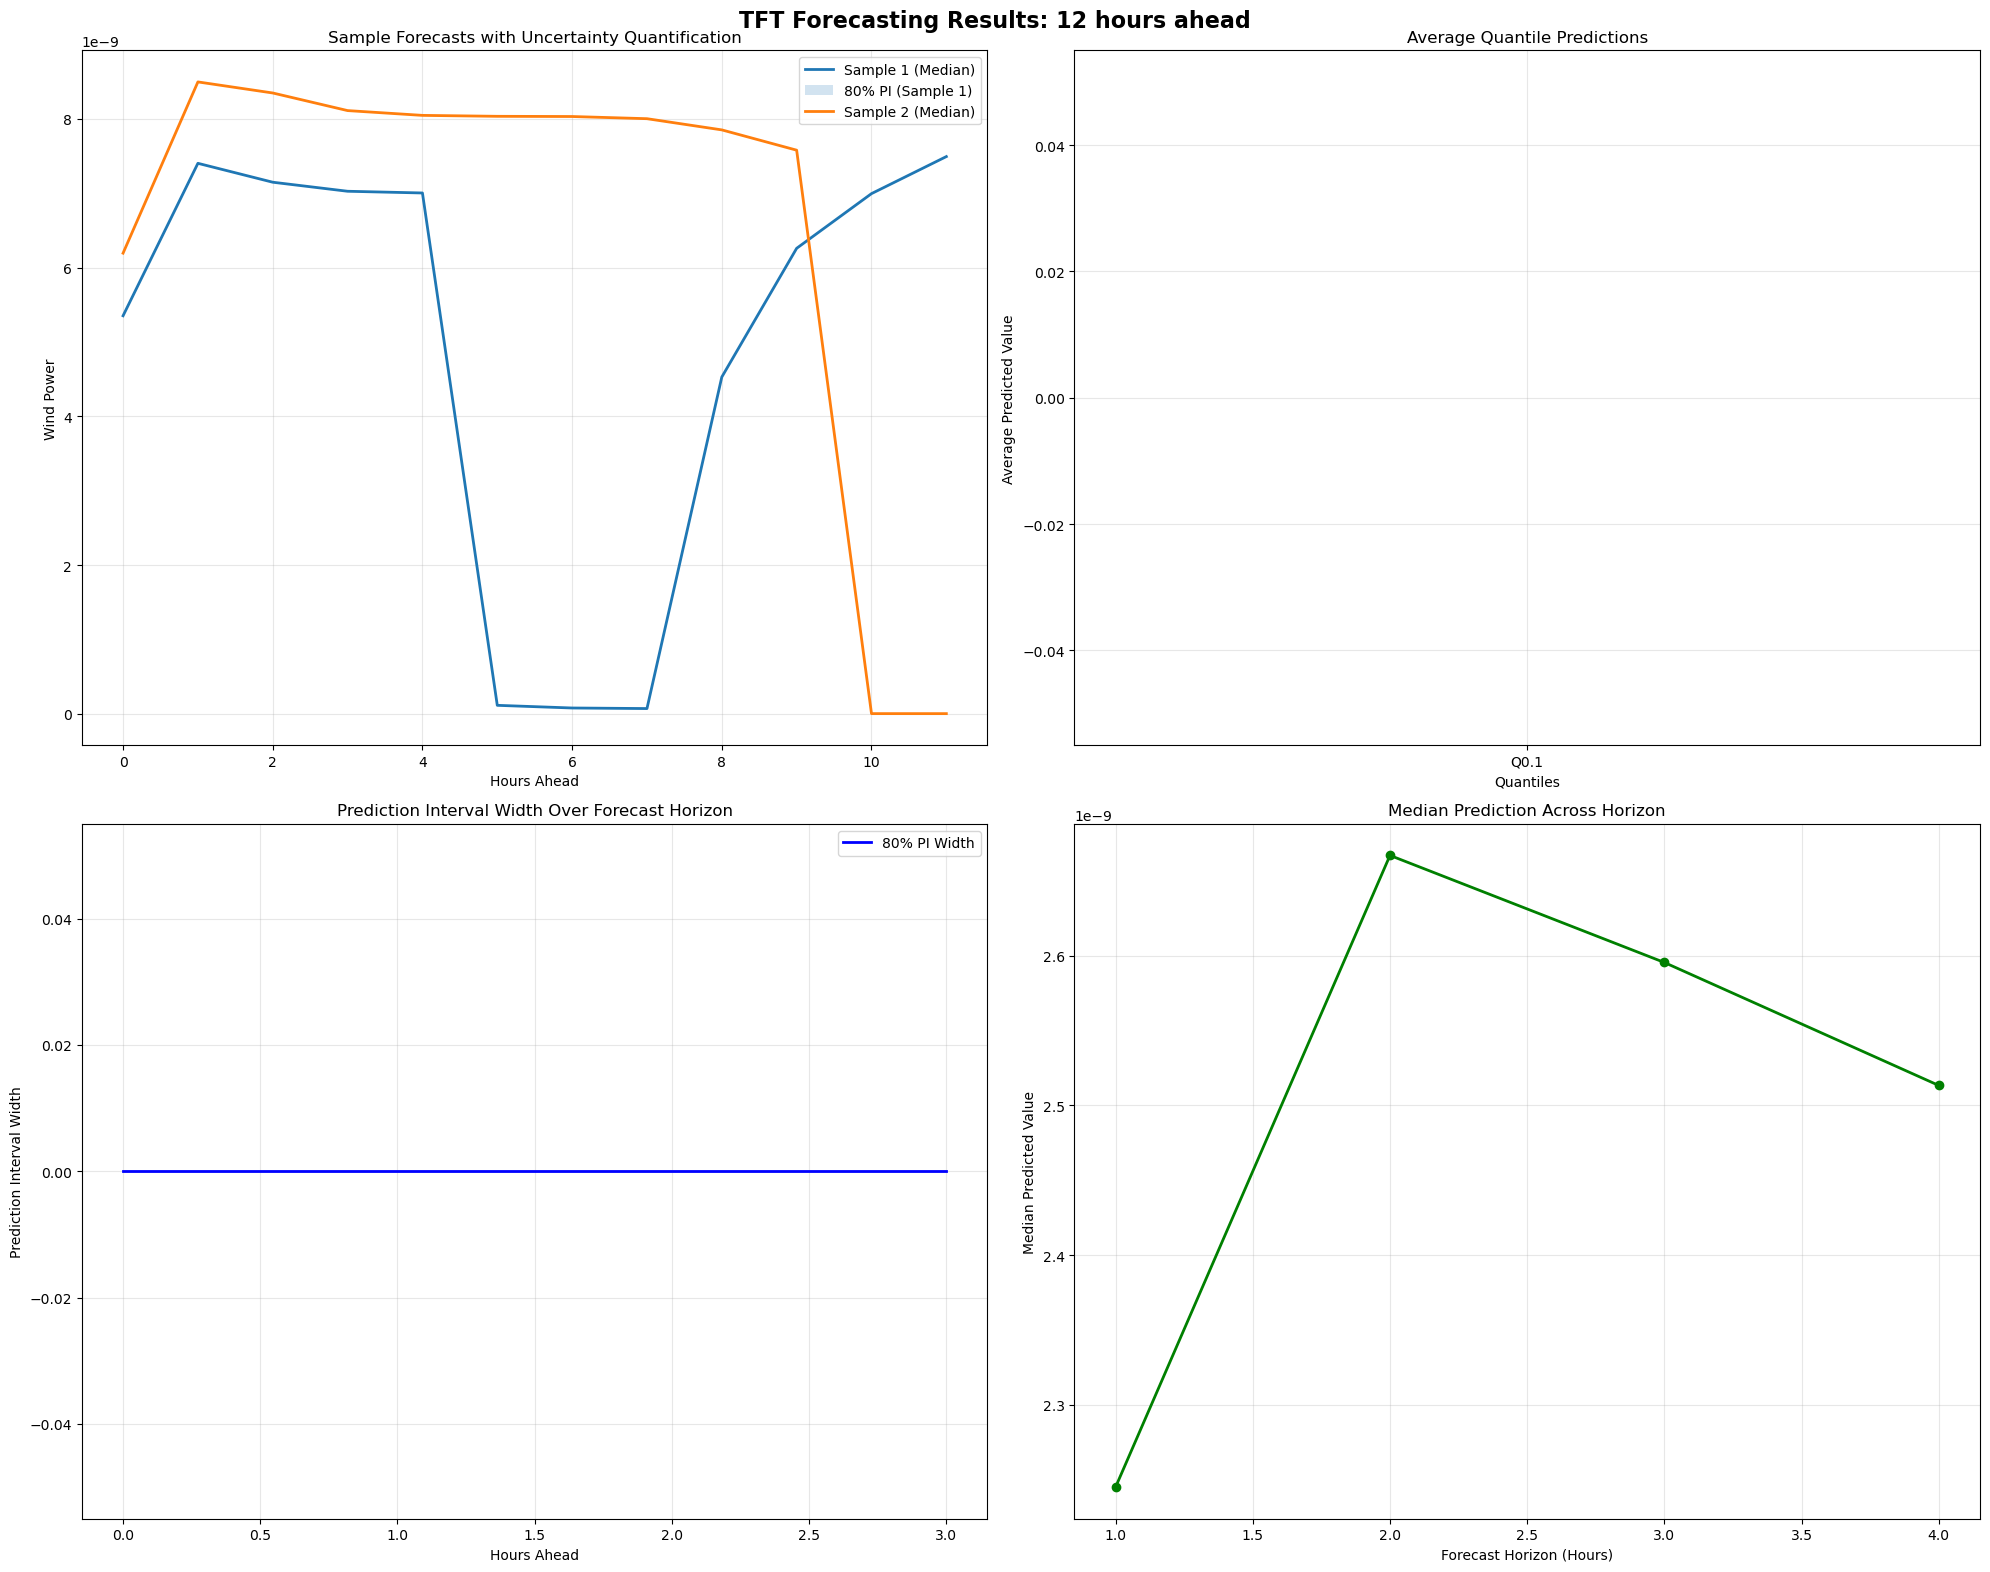


Statistical Summary for 12 hours ahead:
Average median prediction: nan
Prediction std deviation: nan
Average 80% PI width: nan
Forecast horizon: 12 hours
Number of forecasts: 4832


In [ ]:
# Evaluate predictions
eval_results = evaluate_explainable_predictions(best_model, validation_data)

# Plot results
plot_comprehensive_results(eval_results, num_samples=2)
